<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/PostAnnotation/Notebooks/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install pyLDAvis  -qq
!pip install -U jax -qq
!pip install  -U gensim -qq
!pip install spacy  -qq
!pip install matplotlib -qq
!pip install seaborn  -qq
!python -m spacy download en_core_web_md -qq

2023-09-19 06:21:15.830425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 06:21:17.126489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


# Import


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


In [3]:
import seaborn as sns
sns.set()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Mounting Gdrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [5]:
dir  = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/"
dir_actual = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/dataset/annotators raw CSV/Actual/"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Dataset prep

In [6]:
mfc = pd.read_csv(f'{dir}dataset/Extracted-News-May5-7/MFC_prepared.csv', usecols=["code_frames", "annotations"], header=0)
mfc.rename(columns = {'annotations':'Text'}, inplace = True)

mfc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
46794,11.0,Smoking is becoming a social taboo
46795,5.0,Nor does it aid lawyers seeking novel ways to...
46796,15.0,'Ashes to Ashes'
46797,15.0,SMOKE SCREEN IS SEEN BEHIND THE SMOKELESS


In [7]:
ph = pd.read_csv(f'{dir_actual}agreed-PHdataset.csv')
ph.rename(columns = {'Majority-Frame':'code_frames'}, inplace = True)

code_frame_dict_1 = {'1. Economic': 1,
                   '2. Capacity and Resources':2,
                   '3. Morality':3,
                   '4. Fairness and Equality':4,
                   '5. Constitutionality and Jurisprudence':5,
                   '6. Policy Prescription and Evaluation':6,
                   '7. Law and Order, Crime and Justice':7,
                   '8. Security and Defense':8,
                   '9. Health and Safety':9,
                   '10. Quality of Life':10,
                   '11. Cultural Identity':11,
                   '12. Public Opinion':12,
                   '13. Political':13,
                   '14. External Regulation and Reputation':14,
                   '15. Other':15
 }

ph['code_frames'] = ph.code_frames.replace(code_frame_dict_1)


ph

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,code_frames
0,Dumagat-Remontados opposed to Kaliwa Dam urge ...,4
1,The number of Filipinos against changing the C...,12
2,Jinggoy Estrada calls ICC probers 'white monke...,13
3,President Ferdinand “Bongbong” Marcos Jr. has ...,13
4,The Department of Health (DOH) on Thursday mon...,9
...,...,...
12288,PH diplomat tells China not to question PH-US ...,14
12289,Philippine Ambassador to the United States Jos...,14
12290,China enjoins Asian countries to uphold ‘strat...,14
12291,China wants countries in Asia to “uphold strat...,14


In [8]:
all = pd.concat([mfc, ph], axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
all.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
12288,14.0,PH diplomat tells China not to question PH-US ...
12289,14.0,Philippine Ambassador to the United States Jos...
12290,14.0,China enjoins Asian countries to uphold ‘strat...
12291,14.0,China wants countries in Asia to “uphold strat...


# Prepocessing

In [10]:
# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
import spacy

# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
tokens = []

# Assuming 'all' is a DataFrame containing the 'Text' column
for doc in nlp.pipe(all['Text']):
    proj_tok = [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

# Display the tokens
print(tokens)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
# Add tokens to new column
all['tokens'] = tokens
all['tokens']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0            [immigrant, hope, need, help, enter, college]
1                           [eye, law, illegal, immigrant]
2                      [reaction, tancredo, lamm, predict]
3        [say, congressman, happen, opposition, fashion...
4                                                  [entry]
                               ...                        
12288    [ph, diplomat, tell, china, question, ph, mili...
12289    [philippine, ambassador, united, states, jose,...
12290    [china, enjoin, asian, country, uphold, strate...
12291    [china, want, country, asia, uphold, strategic...
12292    [public, tell, remember, honor, emulate, valor...
Name: tokens, Length: 59092, dtype: object

In [13]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(all['tokens'])
print(dictionary.token2id)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'college': 0, 'enter': 1, 'help': 2, 'hope': 3, 'immigrant': 4, 'need': 5, 'eye': 6, 'illegal': 7, 'law': 8, 'lamm': 9, 'predict': 10, 'reaction': 11, 'tancredo': 12, 'argument': 13, 'coherent': 14, 'congressman': 15, 'fashion': 16, 'happen': 17, 'logical': 18, 'opposition': 19, 'say': 20, 'entry': 21, 'break': 22, 'company': 23, 'employ': 24, 'fine': 25, 'full': 26, 'work': 27, 'appeal': 28, 'el': 29, 'end': 30, 'fight': 31, 'hopes': 32, 'hurtado': 33, 'ins': 34, 'salvador': 35, 'stay': 36, 'win': 37, 'year': 38, 'anti': 39, 'backlash': 40, 'bring': 41, 'immigration': 42, 'increase': 43, 'latino': 44, 'resident': 45, 'border': 46, 'head': 47, 'lure': 48, 'mexico': 49, 'migrants': 50, 'open': 51, 'southern': 52, 'abandon': 53, 'accord': 54, 'assault': 55, 'bandit': 56, 'china': 57, 'come': 58, 'corrupt': 59, 'die': 60, 'ecuador': 61, 'government': 62, 'hundred': 63, 'journey': 64, 'leg': 65, 'number': 66, 'officer': 67, 'official': 68, 'police': 69, 'price': 70, 'rape': 71, 'report': 

In [14]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in all['tokens']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


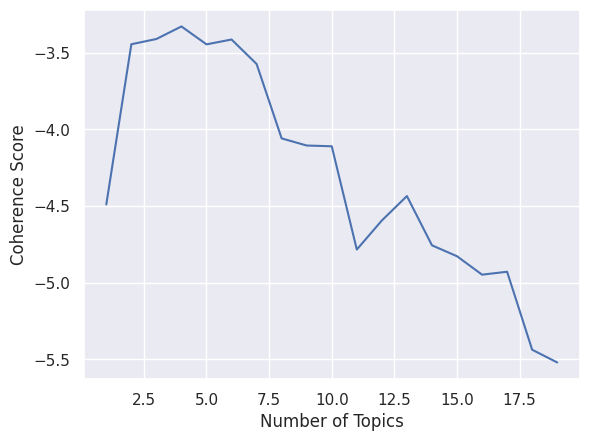

In [15]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = all['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

In [ ]:
#Print topics
lda_model.print_topics(-1)

# Where does a text belong to
lda_model[corpus][0]
all['Text'][0]

# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

# Save the report
pyLDAvis.save_html(lda_display, 'index.html')